## 1.数据预处理
-----
### 1.1导入相关库

In [7]:
import os
import shutil
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import glob  
import cv2
from PIL import Image
import matplotlib.image as mpimg

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
from scipy.ndimage import imread
%matplotlib inline


### 1.2 将训练集数据分成猫和狗两个文件

In [1]:
# Divide the training set into two folders for cats and dogs
n_classes = ['cat','dog']

for i in range(len(n_classes)):
    if not os.path.exists('./' + n_classes[i]):
        os.makedirs('./' + n_classes[i])
        train_filenames = os.listdir('train')
        for i in range(len(train_filenames)):
            train_file_path = os.path.join('./train', train_filenames[i])
            if 'cat' in train_file_path.split('\\')[-1]:
                new_file_path_cat = './cat'
                shutil.move(train_file_path, new_file_path_cat)
            else:
                new_file_path_dog = './dog'
                shutil.move(train_file_path, new_file_path_dog)

## 2.显示训练集图片
-----
### 2.1 随机显示9个图片

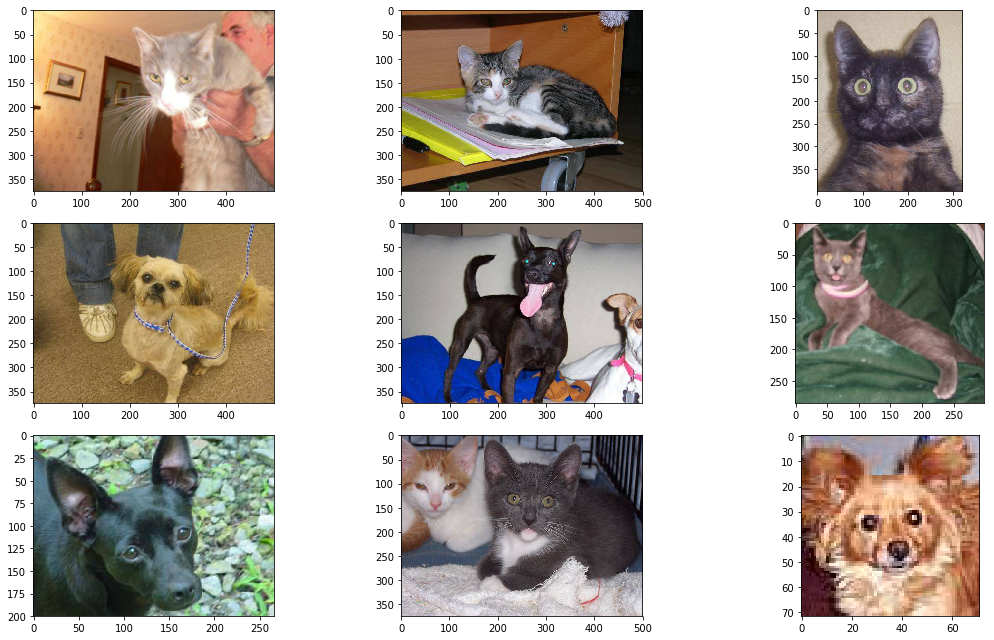

In [13]:
plt.figure(figsize=(16, 9))
for i in range(9):
    plt.subplot(331 + i)
    image_name = random.randint(1, 12500)
    img = mpimg.imread('./test/test/' + str(image_name) + '.jpg')
    plt.tight_layout()
    plt.imshow(img)

### 2.2 分析异常值图片

In [4]:
img = []
img_path = glob.glob('./train/train/*.jpg')

# Create name is different folder
if not os.path.exists('./different'):
    os.makedirs('./different')

for fname in img_path:
    """
    The getcolors() function is the number of times each color appears in the image.
    Since the color distribution of the exception values image is different from normal,
    I choose to keep the number of colors that appear at most 5101 to the lowest color, which is 139.
    (Distribution of color characteristics according to outliers.)
    
    Result :Finally, We get 1325 images can be selected to quickly locate the abnormal value images.
            then put the exception values you see in the different_value folder.
    """
    
    img = Image.open(fname)
    
    # Image size: Screen images using image size(Height: 330, width: 289)
    if img.size[0] < 330 and img.size[1] < 289:    
        
        # Color type: The color of the picture is less than 20,300.
        if len(img.getcolors(888888)) < 20300:    
            
            count_color = []
            color_img = img.getcolors(888888)
            
            # Get the number of times the colors appear.
            list_color = [i[0] for i in color_img]
            
            # Filter color to appear 1 time data.
            for i in list_color:                  
                if i > 1:
                    count_color.append(i)
            
            # If the color appears in the range of 5101 to 139, save the image to different folder.
            if 5101 > len(count_color) > 139:     
                shutil.copy(fname, './different')

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


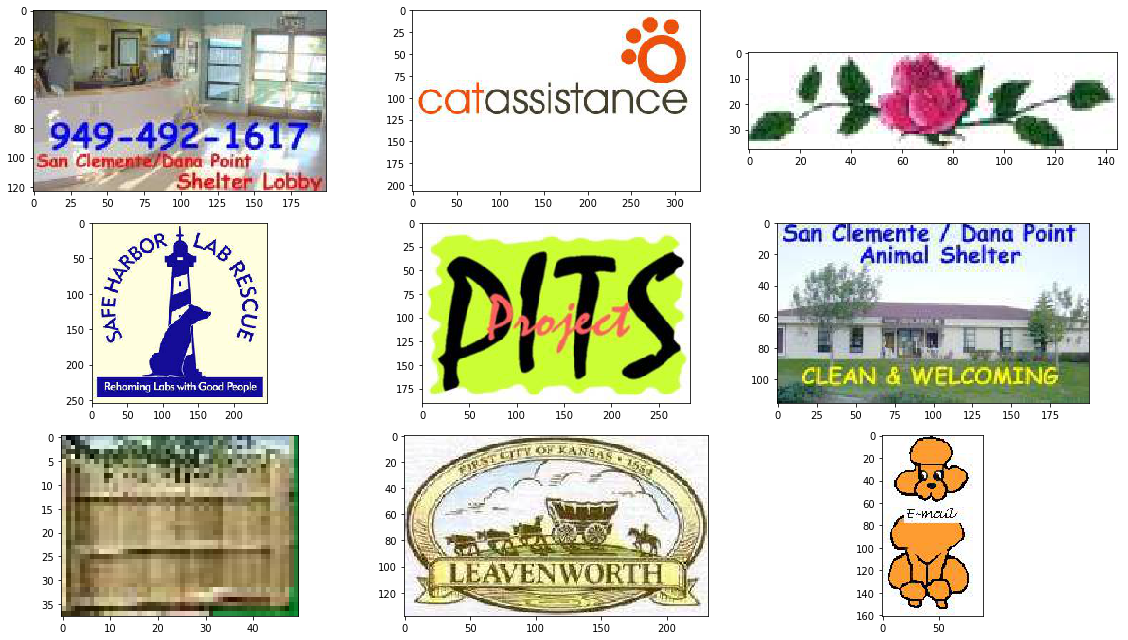

In [13]:
d_path = glob.glob('./different_value/*.jpg')

plt.figure(figsize=(16, 9))
for i in range(len(d_path)-5):
    plt.subplot(331 + i)

    img = imread(d_path[i])
    plt.tight_layout()
    plt.imshow(img)

## 3.提取特征

In [ ]:
classes = ['cat', 'dog']
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    # Build the vgg network here
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope('content_vgg'):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = path + '\\' + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # Get the values from the relu6 layer of the VGG network
                feed_dict = {input_:images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

## 4.保存特征提取器

In [6]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## 5.读取特征

In [2]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

In [4]:
len(codes)

25000

## 6.数据预处理
----
### 6.1独热编码

In [5]:
# one-hot code the labels
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels) # Your one-hot encoded labels array here

In [6]:
labels_vecs

array([[0],
       [0],
       [0],
       ..., 
       [1],
       [1],
       [1]])

### 6.2优化独热编码后的值

In [7]:
# fine-tuning the labels
list_labels = []
for i in range(len(labels_vecs)):
    list_labels.append(list(labels_vecs[i]))

re_list_labels = list(reversed(list_labels))
all_labels = []
for ii in range(len(list_labels)):
    all_labels.append(list_labels[ii] + re_list_labels[ii])

labels_vecs = np.array(all_labels)
labels_vecs[0]

### 6.3拆分训练集：训练集为80%，验证集为20%

In [14]:
# Divide training data into 80%, verify set 10%, test set 10%
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels))

half_val_len = int(len(val_idx)/2)
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]


train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y =  codes[test_idx], labels_vecs[test_idx]

In [15]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (20000, 4096) (20000, 2)
Validation shapes (x, y): (2500, 4096) (2500, 2)
Test shapes (x, y): (2500, 4096) (2500, 2)


## 7.构建模型

In [67]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

# Classifier layers and operations
fc7 = tf.contrib.layers.fully_connected(inputs_, 1024)

logits = tf.contrib.layers.fully_connected(fc7, labels_vecs.shape[1], activation_fn=None)# output layer logits
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(cross_entropy)# cross entropy loss

optimizer = tf.train.AdamOptimizer().minimize(cost)# training optimizer

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### 7.1 创建批处理数据函数。

In [68]:
# Build batch processing data functions
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

## 8.训练模型

In [69]:
epochs = 10
iteration = 0
saver = tf.train.Saver()


losses = {'train':[], 'validation':[]}

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print('Epoch: {}/{}'.format(e+1, epochs),
                 'Iteration:{}'.format(iteration),
                 'Training loss:{:.5f}'.format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print('Epoch:{}/{}'.format(e, epochs),
                      'Iteration: {}'.format(iteration),
                      'Validation Acc: {:.4f}'.format(val_acc))
                
            losses['train'].append(loss)
#             losses['validation'].append(val_acc)

    saver.save(sess, "checkpoints/cat_dog.ckpt")

Epoch: 1/10 Iteration:0 Training loss:7.65454
Epoch: 1/10 Iteration:1 Training loss:43.48581
Epoch: 1/10 Iteration:2 Training loss:21.25665
Epoch: 1/10 Iteration:3 Training loss:3.53567
Epoch: 1/10 Iteration:4 Training loss:0.34978
Epoch:0/10 Iteration: 5 Validation Acc: 0.9692
Epoch: 1/10 Iteration:5 Training loss:0.29468
Epoch: 1/10 Iteration:6 Training loss:0.90622
Epoch: 1/10 Iteration:7 Training loss:1.27985
Epoch: 1/10 Iteration:8 Training loss:1.55338
Epoch: 1/10 Iteration:9 Training loss:1.45038
Epoch:0/10 Iteration: 10 Validation Acc: 0.9124
Epoch: 2/10 Iteration:10 Training loss:1.48240
Epoch: 2/10 Iteration:11 Training loss:1.26812
Epoch: 2/10 Iteration:12 Training loss:1.01350
Epoch: 2/10 Iteration:13 Training loss:0.82455
Epoch: 2/10 Iteration:14 Training loss:0.54866
Epoch:1/10 Iteration: 15 Validation Acc: 0.9540
Epoch: 2/10 Iteration:15 Training loss:0.40051
Epoch: 2/10 Iteration:16 Training loss:0.34346
Epoch: 2/10 Iteration:17 Training loss:0.19649
Epoch: 2/10 Iterati

### 8.1显示损失值

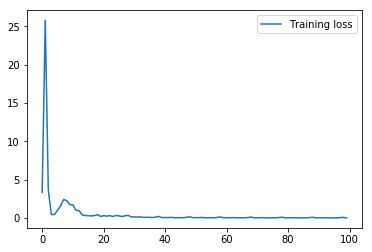

In [36]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

### 8.2显示准确率

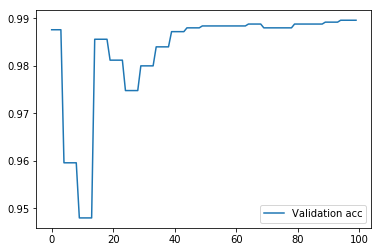

In [37]:
plt.plot(losses['validation'], label='Validation acc')
plt.legend()
_ = plt.ylim()

## 9.测试模型

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\cat_dog.ckpt
Test accuracy: 0.9920


### 9.1自带测试集验证

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


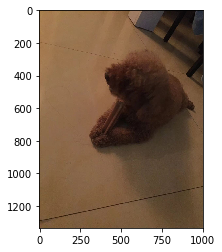

In [70]:
test_img_path = r'D:\猫狗大战\Kaggle：Dogs vs. Cats\test\12501.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

### 9.2运行训练好的模型

In [71]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [72]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from checkpoints\cat_dog.ckpt


### 9.3显示预测结果

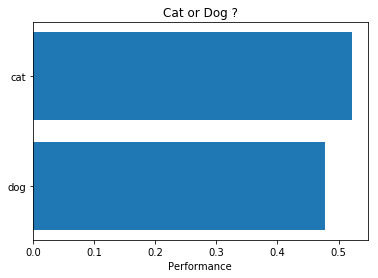

In [74]:
animal = ['dog','cat']
plt.barh(np.arange(2), prediction)
plt.yticks(np.arange(2), animal)
plt.xlabel('Performance')
plt.title('Cat or Dog ?')
plt.savefig("barh.png",format="png")